# Laboratorio 9 - Visualización Interactiva

### Cristian Laynez 201281
### Josué Sagastume 18173

## Paleta de colores seleccionada:
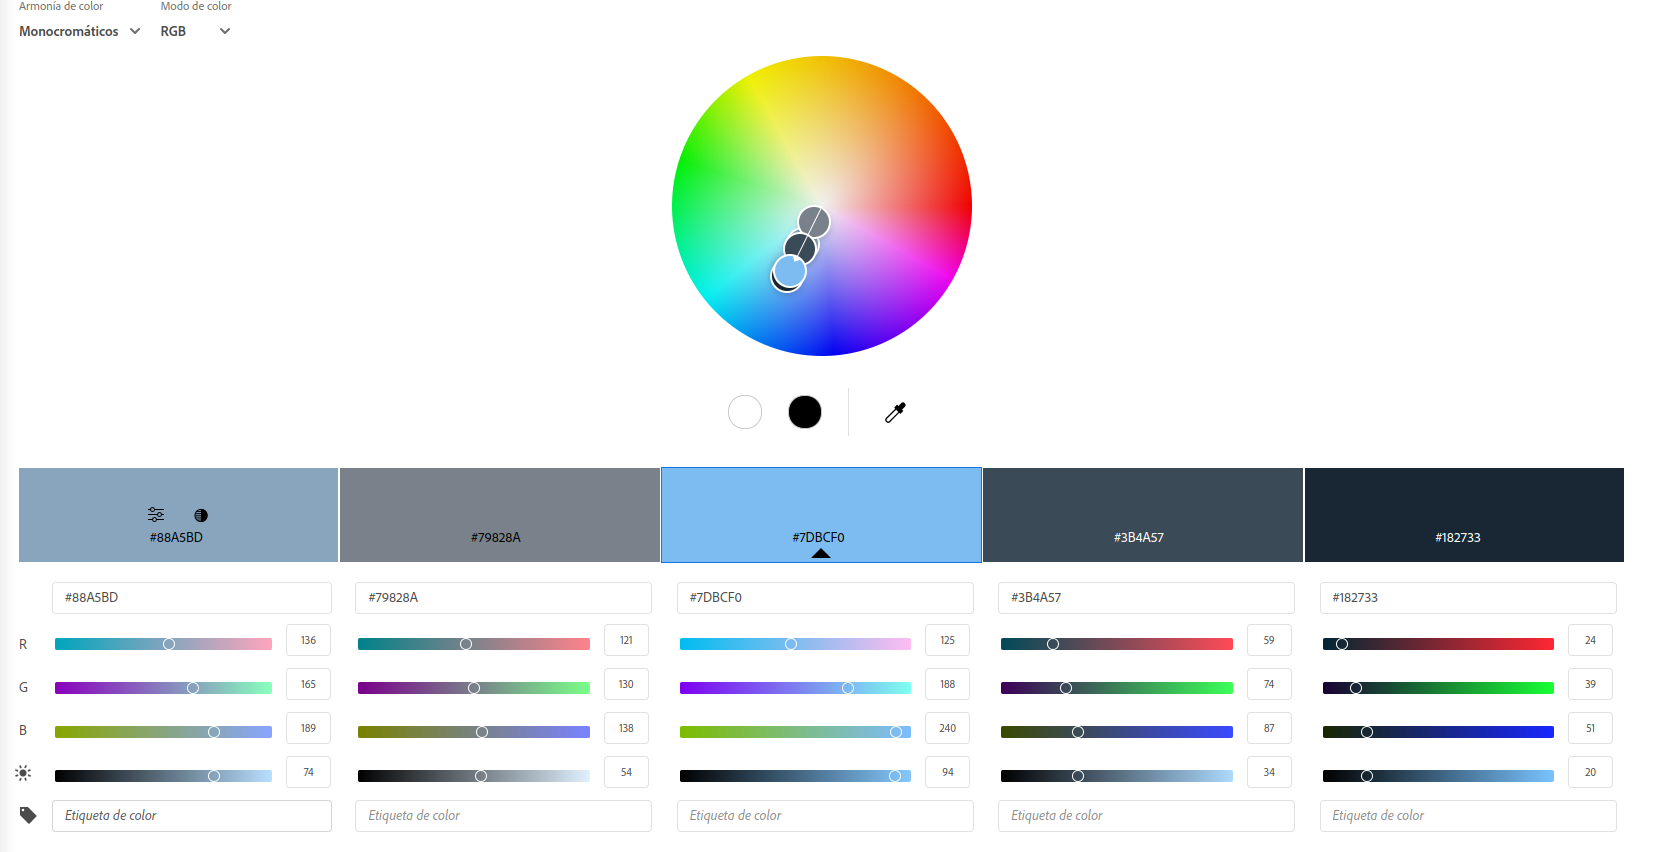

In [222]:
COLORS = [
    f"#7DBBEF",
    f"#3B4A57",
    f"#79828A",
    f"#88A5BD",
    f"#182733",
]

## Selección de la herramienta a utilizar:

Se utilizará Voilá.

Vamos a reutilizar el código del laboratorio 6 (ya que este fue el lab seleccionado para hacer la visualización)

In [223]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [224]:
# Importar librerias
import pandas as pd
import random
import nltk
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# from bqplot import pyplot as plt
import ast

In [225]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display

In [226]:
from nltk import bigrams
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [227]:
import ipywidgets as widgets

In [228]:
# Cargar data ya limpia extraida del laboratorio 6
data = pd.read_csv('./drive/Shareddrives/DataScience-DataSets/traficogt_clean.csv')

### Analisis exploratorio

In [229]:
lang_count = data["lang"].value_counts().head(3)

df = pd.DataFrame({'Lenguajes': lang_count.index, 'Porcentaje': lang_count.values})

colores_personalizados = [COLORS[0], COLORS[1], COLORS[2]]

# Crear la gráfica de pastel interactiva con Plotly Express
fig = px.pie(df, values='Porcentaje', names='Lenguajes', title='Porcentaje de Lenguajes en Tweets', color_discrete_sequence=colores_personalizados)

# Mostrar la gráfica interactiva utilizando Voilà
fig.show()

In [230]:
tweets_by_year = data["year"].value_counts().head(5)

# Crear una figura de plotly
fig = make_subplots()
fig.add_trace(go.Bar(x=tweets_by_year.index, y=tweets_by_year, marker_color=COLORS[1]))

# Configurar el diseño de la gráfica
fig.update_layout(
    xaxis_title='Año',
    yaxis_title='Cantidad de Tweets',
    title='Cantidad de Tweets por Año',
    xaxis=dict(tickangle=45, tickmode='array', tickvals=list(tweets_by_year.index), ticktext=list(tweets_by_year.index)),
)

# Inicializar el widget de barra de rango
year_range_slider = widgets.IntRangeSlider(
    value=[data['year'].min(), data['year'].max()],
    min=data['year'].min(),
    max=data['year'].max(),
    step=1,
    description='Año',
    continuous_update=False  # Para evitar actualizaciones continuas mientras se arrastra
)

# Función para actualizar la gráfica cuando cambia el rango de años
def update_bar_chart(year_range):
    filtered_data = data[(data['year'] >= year_range[0]) & (data['year'] <= year_range[1])]
    tweets_by_year = filtered_data['year'].value_counts().sort_index()

    fig.data = []  # Limpiar las trazas existentes
    fig.add_trace(go.Bar(x=tweets_by_year.index, y=tweets_by_year, marker_color='blue'))

# Mostrar la figura inicial
fig.show()

In [244]:
combined_text_rawContent = ' '.join(data["rawContent"].astype(str))

In [245]:
def generate_wordcloud(max_words):
    wordcloud = WordCloud(
        background_color='white',
        width=800,
        height=400,
        max_words=max_words,
        collocations=False,
        colormap='viridis',
        color_func=lambda *args, **kwargs: COLORS[3],
        prefer_horizontal=1.0,
        random_state=42
    ).generate(combined_text_rawContent)

    for idx, (word, font_size, position, orientation, color) in enumerate(wordcloud.layout_):
        wordcloud.layout_[idx] = (word, font_size, position, orientation, COLORS[random.randint(0, 2)])

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nube de Palabras para contenido de texto de los Tweets')
    plt.show()

max_words_slider = widgets.IntSlider(
    value=30,
    min=1,
    max=100,
    step=1,
    description='Max Words',
    continuous_update=False
)

widgets.interactive(generate_wordcloud, max_words=max_words_slider)

interactive(children=(IntSlider(value=30, continuous_update=False, description='Max Words', min=1), Output()),…

In [233]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12631 entries, 0 to 12630
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            12631 non-null  object 
 1   lang            12631 non-null  object 
 2   rawContent      12603 non-null  object 
 3   replyCount      12631 non-null  int64  
 4   retweetCount    12631 non-null  int64  
 5   likeCount       12631 non-null  int64  
 6   quoteCount      12631 non-null  int64  
 7   hashtags        12631 non-null  object 
 8   viewCount       12631 non-null  float64
 9   place           12631 non-null  object 
 10  sourceLabel     12631 non-null  object 
 11  username        12631 non-null  object 
 12  rawDescription  12406 non-null  object 
 13  year            12631 non-null  int64  
dtypes: float64(1), int64(5), object(8)
memory usage: 1.3+ MB


In [234]:
import ipywidgets as widgets
import pandas as pd

In [235]:
selector_columna = widgets.Dropdown(
    options=data.columns,
    description='Columna:',
    disabled=False,
)

In [236]:
def mostrar_datos(columna):
    return data[columna].value_counts().head(10)

In [237]:
widgets.interactive(mostrar_datos, columna=selector_columna)

interactive(children=(Dropdown(description='Columna:', options=('date', 'lang', 'rawContent', 'replyCount', 'r…

### Modelos de machine learning

In [238]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import plotly.express as px

In [239]:
X = data[['replyCount', 'retweetCount', 'quoteCount']]
y = data['likeCount']

In [240]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [241]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [242]:
def plot_feature(columna):
    fig = px.histogram(data, x=columna)
    fig.show()

In [243]:
widgets.interactive(plot_feature, columna=selector_columna)

interactive(children=(Dropdown(description='Columna:', options=('date', 'lang', 'rawContent', 'replyCount', 'r…